# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [42]:
from tax_credit.taxa_manipulator import *
from tax_credit.framework_functions import *
from tax_credit.eval_framework import heatmap_from_data_frame, parameter_comparisons, method_by_dataset

from os import path, makedirs, remove, rename
from os.path import expandvars, join
from IPython.display import display

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")
analysis_name = "simulated-community"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
if not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [4]:
color_pallette = dict(rdp="seagreen", sortmerna="gray", uclust="blue")

level_results = extract_per_level_accuracy(accuracy_results, group_by="Dataset")

y_vars = ["match_ratio"]

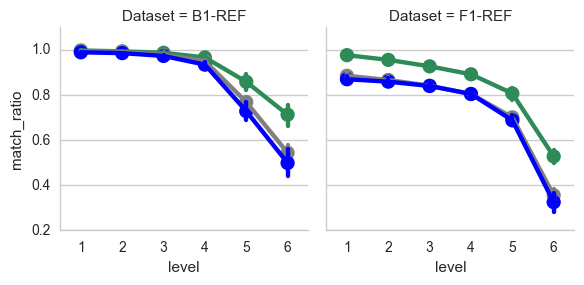

In [10]:
pointplot_from_data_frame(level_results, "level", y_vars,
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [11]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset     Variable             1             2             3  \
0  B1-REF  match_ratio  2.916214e-07  2.916214e-07  7.984656e-07   
1  F1-REF  match_ratio  2.296467e-14  1.588571e-13  4.075195e-11   

              4             5             6  
0  6.754550e-05  7.075763e-06  3.741435e-06  
1  8.886172e-09  1.623722e-08  1.623722e-08

## Heatmap of method accuracy by parameter

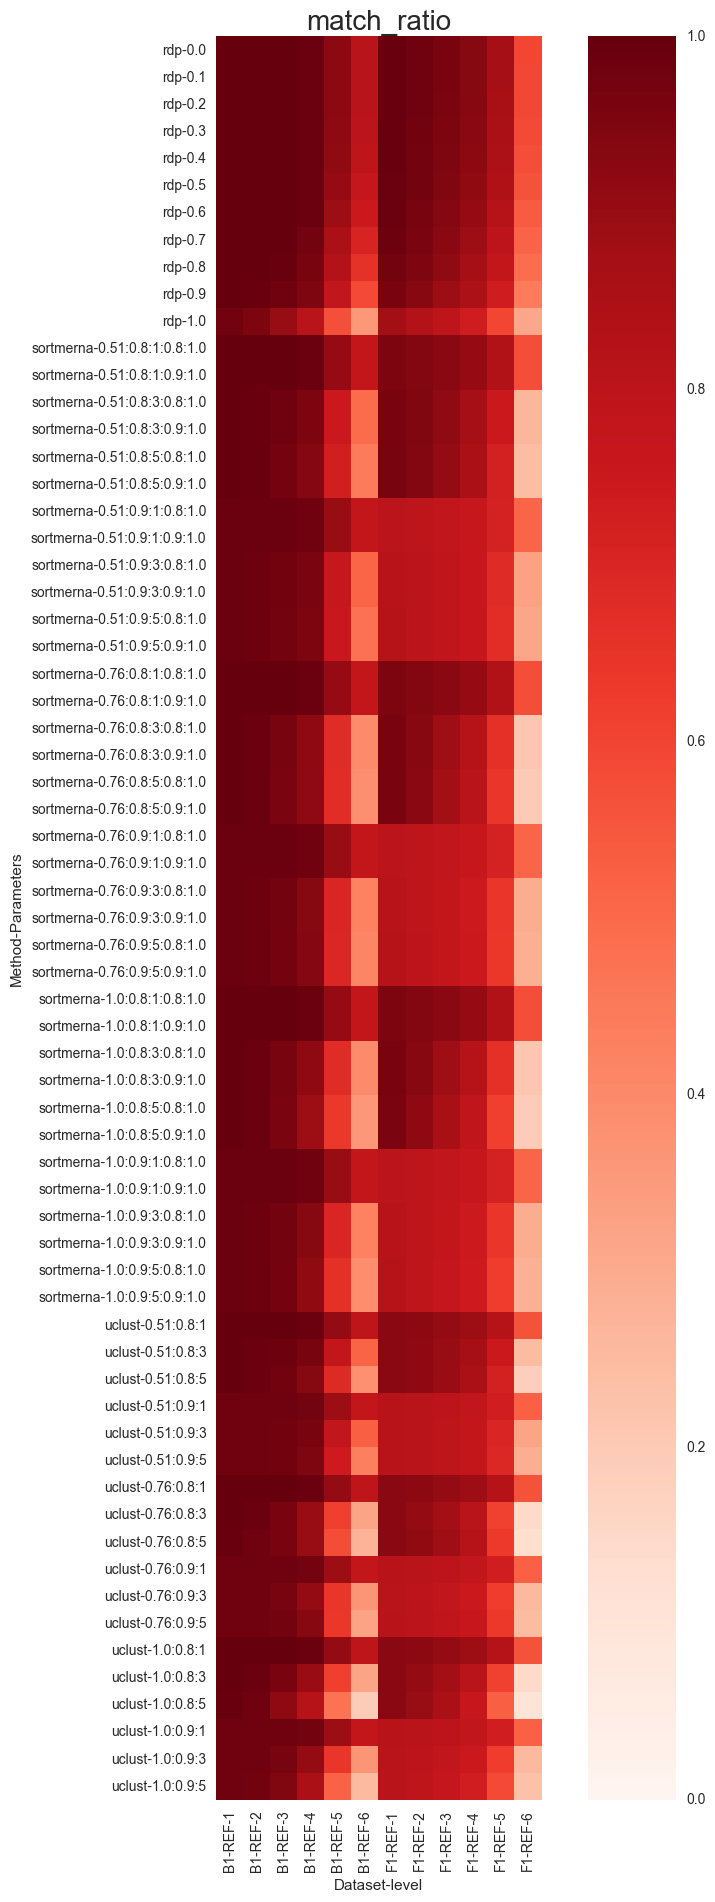

In [6]:
heatmap_from_data_frame(level_results, metric="match_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* column indicates how many samples a given method achieved within one mean absolute deviation of the best result (which is why they sum to more than the total number of samples).

In [43]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    print(method)
    display(top_params[:10])

rdp


match_ratio
0.0           28
0.1           28
0.2           28
0.3           28
0.4           27
0.5           26
0.6           26
0.7           24
0.8           23
0.9           21

sortmerna


match_ratio
0.51:0.8:1:0.8:1.0           29
1.0:0.8:1:0.8:1.0            29
0.51:0.8:1:0.9:1.0           29
0.76:0.8:1:0.9:1.0           29
0.76:0.8:1:0.8:1.0           29
1.0:0.8:1:0.9:1.0            29
0.51:0.8:5:0.9:1.0           24
0.51:0.8:5:0.8:1.0           24
0.51:0.8:3:0.9:1.0           24
0.51:0.8:3:0.8:1.0           24

uclust


match_ratio
0.51:0.8:1           31
0.76:0.8:1           31
1.0:0.8:1            31
1.0:0.9:1            26
0.76:0.9:1           26
0.51:0.9:1           26
0.51:0.8:3           25
0.76:0.8:3           24
0.76:0.8:5           24
1.0:0.8:3            24

Now we rank the top-performing method/parameter combination for each method from family to species level

In [45]:
for dataset in level_results['Dataset'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(level_results[level_results["level"] == level],
                                        dataset=dataset, sort_field='match_ratio',
                                        display_fields=("Method", "Parameters", "match_ratio"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

B1-REF level 4


Method          Parameters  match_ratio
921   sortmerna  0.76:0.8:1:0.8:1.0          1.0
795         rdp                 0.2          1.0
1137     uclust           1.0:0.8:1          1.0

B1-REF level 5


Method          Parameters  match_ratio
412        rdp                 0.3     0.961326
748     uclust           1.0:0.8:1     0.944751
538  sortmerna  0.76:0.8:1:0.9:1.0     0.944751

B1-REF level 6


Method          Parameters  match_ratio
539  sortmerna  0.76:0.8:1:0.9:1.0     0.883978
395        rdp                 0.0     0.872928
677     uclust          0.51:0.8:1     0.872928

F1-REF level 4


Method          Parameters  match_ratio
1563        rdp                 0.0     0.947547
1629  sortmerna  0.51:0.8:1:0.8:1.0     0.923858
1845     uclust          0.51:0.8:1     0.898477

F1-REF level 5


Method         Parameters  match_ratio
1564        rdp                0.0     0.886633
1780  sortmerna  1.0:0.8:1:0.9:1.0     0.859560
1882     uclust         0.76:0.8:1     0.835871

F1-REF level 6


Method         Parameters  match_ratio
1175        rdp                0.0     0.614767
1775  sortmerna  1.0:0.8:1:0.8:1.0     0.582064
1457     uclust         0.51:0.8:1     0.573034